# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

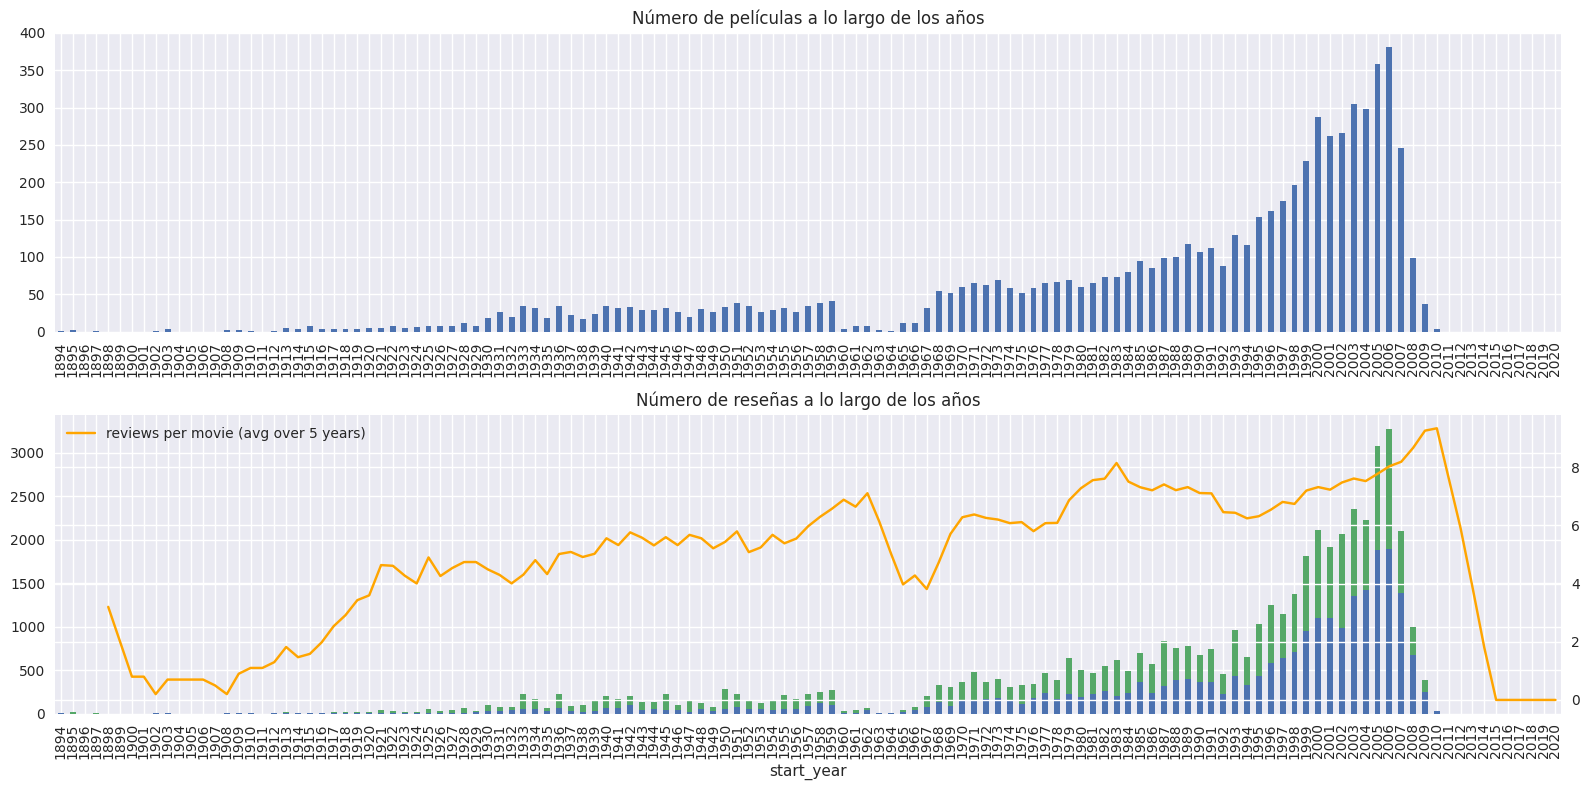

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

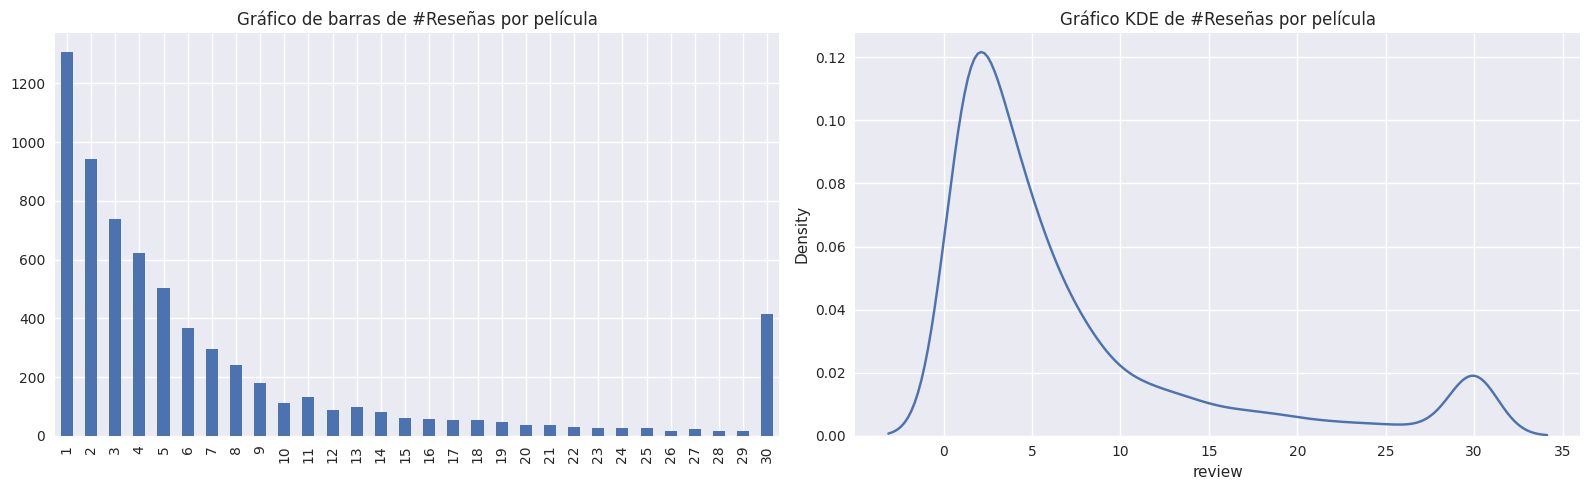

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

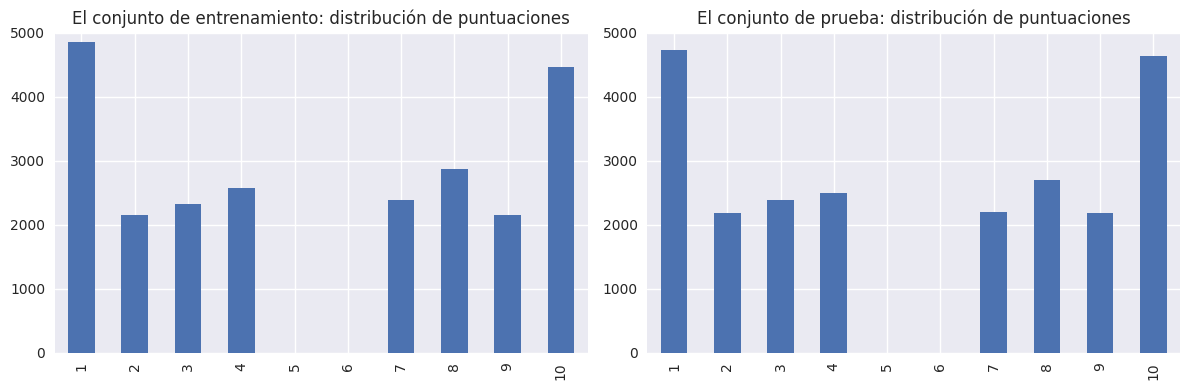

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


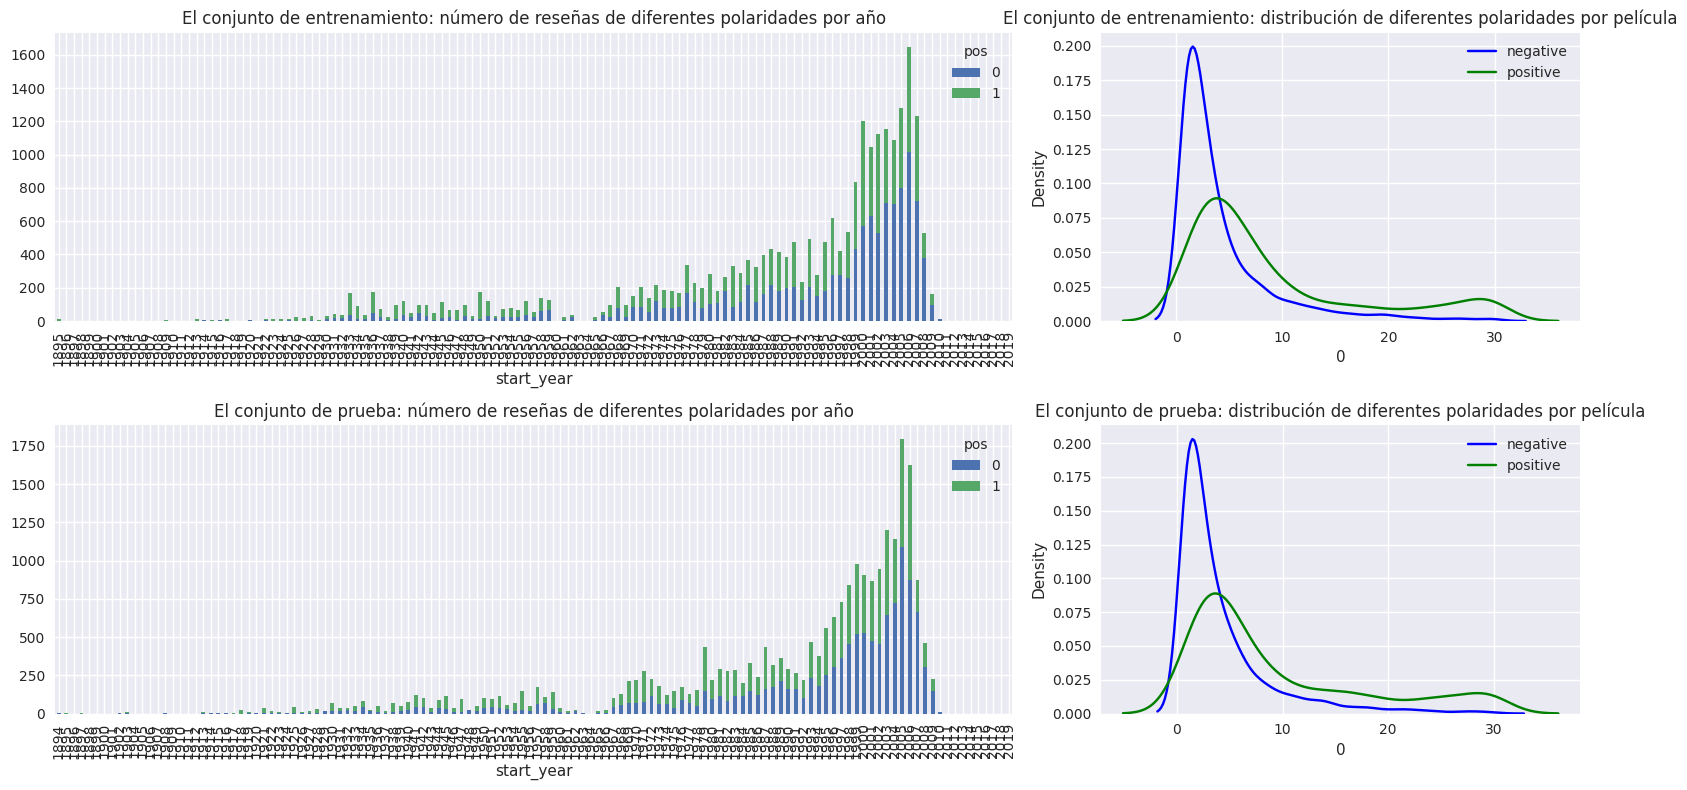

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return



<div class="alert alert-block alert-warning">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Atención</b> ⚠️ - ¡Muy bien hecho! Has seguido la plantilla del proyecto con mucha precisión: los pasos están claramente estructurados, la exploración inicial es profunda, y el procedimiento de evaluación está bien diseñado y visualmente robusto. 👏

Sin embargo, en la sección de **evaluación del modelo**, hay un pequeño error conceptual: al momento de presentar las métricas en el `DataFrame`, se utiliza `df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))`, pero la clave `'Exactitud'` no existe como tal en el diccionario generado. Esto puede causar errores o resultados vacíos en la tabla de métricas. Deberías usar `'Accuracy'`, que es el nombre correcto definido previamente. ¡Corrigiendo eso, tu evaluación quedará perfecta!

¡Sigue así, vas por excelente camino!

</div>


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
df_reviews['review_norm'] = (
    df_reviews['review']
    .str.lower()  # minúsculas
    .str.replace(r'[^a-z\s]', '', regex=True)  # elimina signos de puntuación y números
    .str.replace(r'\s+', ' ', regex=True)  # colapsa múltiples espacios
    .str.strip()  # elimina espacios al principio y al final
)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [14]:
from sklearn.dummy import DummyClassifier

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


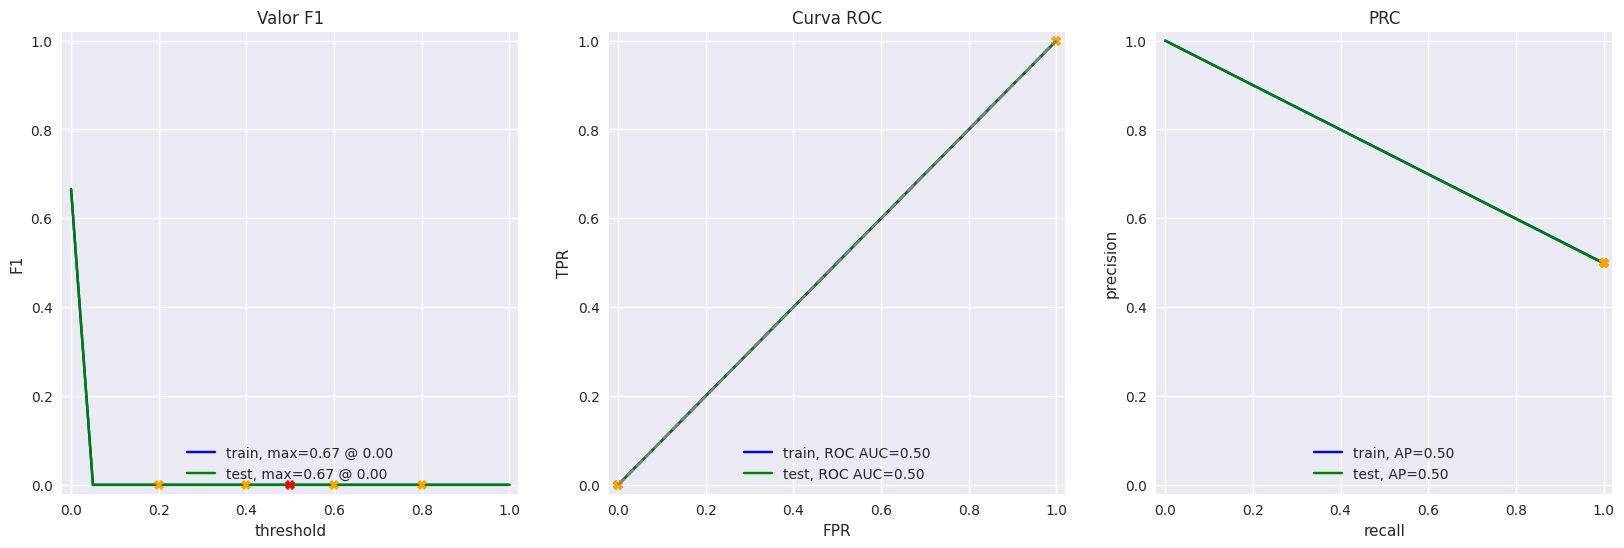

In [15]:
train_features_0 = np.zeros((len(train_target), 1))
test_features_0 = np.zeros((len(test_target), 1)) 

model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_features_0, train_target)  # train_features_0 sería algo simple (por ejemplo, un vector con ceros)
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def preprocess_text_nltk(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df_reviews_train['review_nltk'] = df_reviews_train['review'].progress_apply(preprocess_text_nltk)
df_reviews_test['review_nltk'] = df_reviews_test['review'].progress_apply(preprocess_text_nltk)

vectorizer_1 = TfidfVectorizer(max_features=5000)
train_features_1 = vectorizer_1.fit_transform(df_reviews_train['review_nltk'])
test_features_1 = vectorizer_1.transform(df_reviews_test['review_nltk'])

model_1 = LogisticRegression(max_iter=500)
model_1.fit(train_features_1, train_target)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

LogisticRegression(max_iter=500)

           train  test
Exactitud    NaN   NaN
F1          0.92  0.88
APS         0.97  0.95
ROC AUC     0.97  0.95


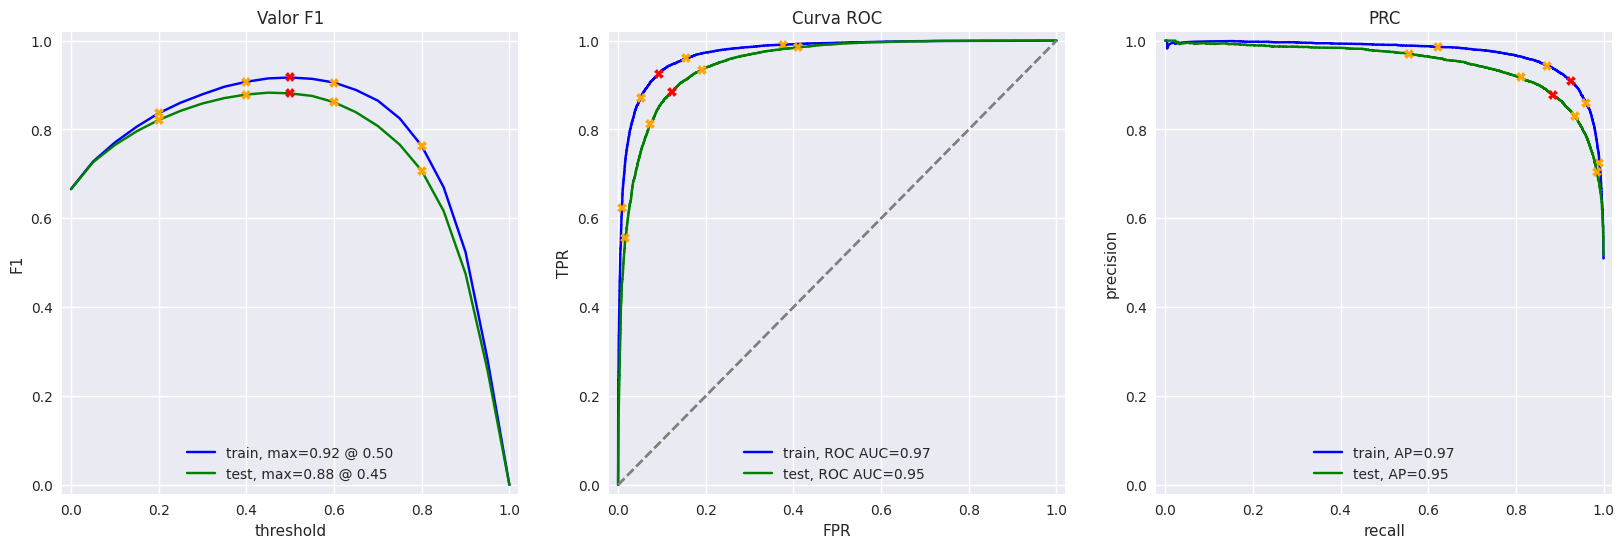

In [19]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

In [22]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [23]:
vectorizer_3 = TfidfVectorizer(max_features=5000)
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_spacy'])

In [24]:
model_3 = LogisticRegression(max_iter=500)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=500)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.87
APS         0.97  0.94
ROC AUC     0.97  0.95


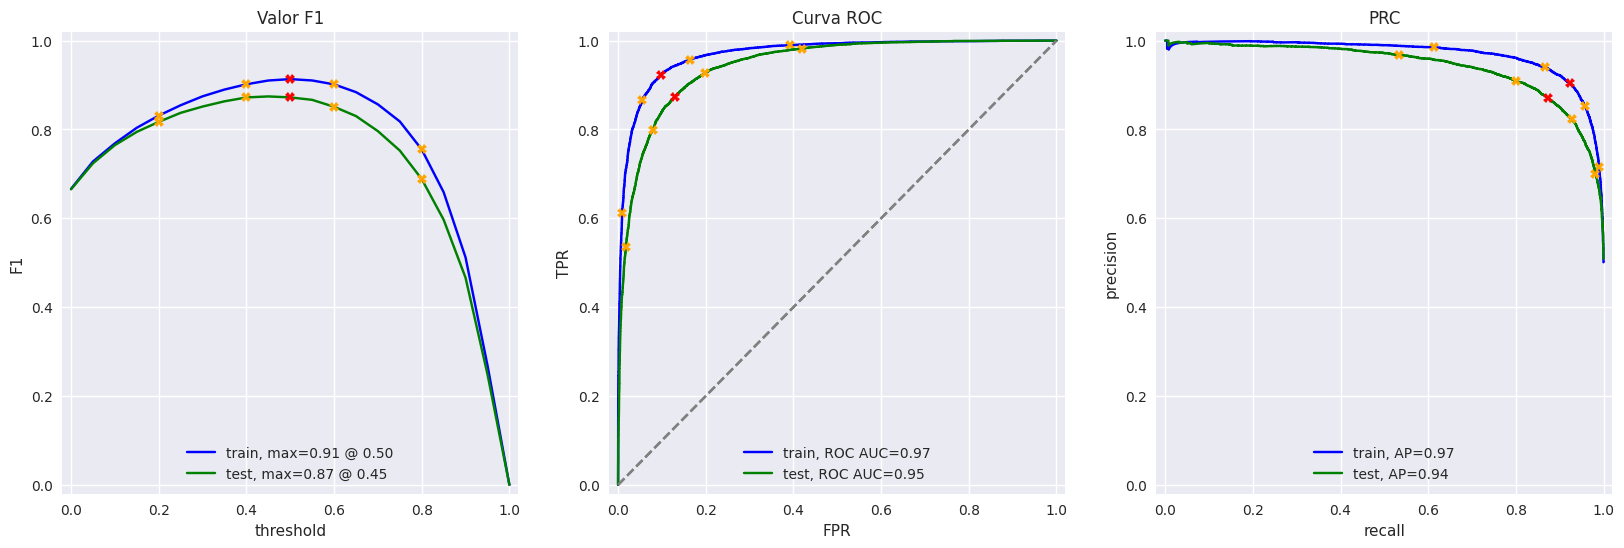

In [25]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [26]:
from lightgbm import LGBMClassifier

In [27]:
model_4 = LGBMClassifier(n_estimators=1000)
model_4.fit(train_features_3, train_target)  # usa las features spaCy/TF-IDF de 7.3

LGBMClassifier(n_estimators=1000)

           train  test
Exactitud    NaN   NaN
F1           1.0  0.87
APS          1.0  0.94
ROC AUC      1.0  0.94


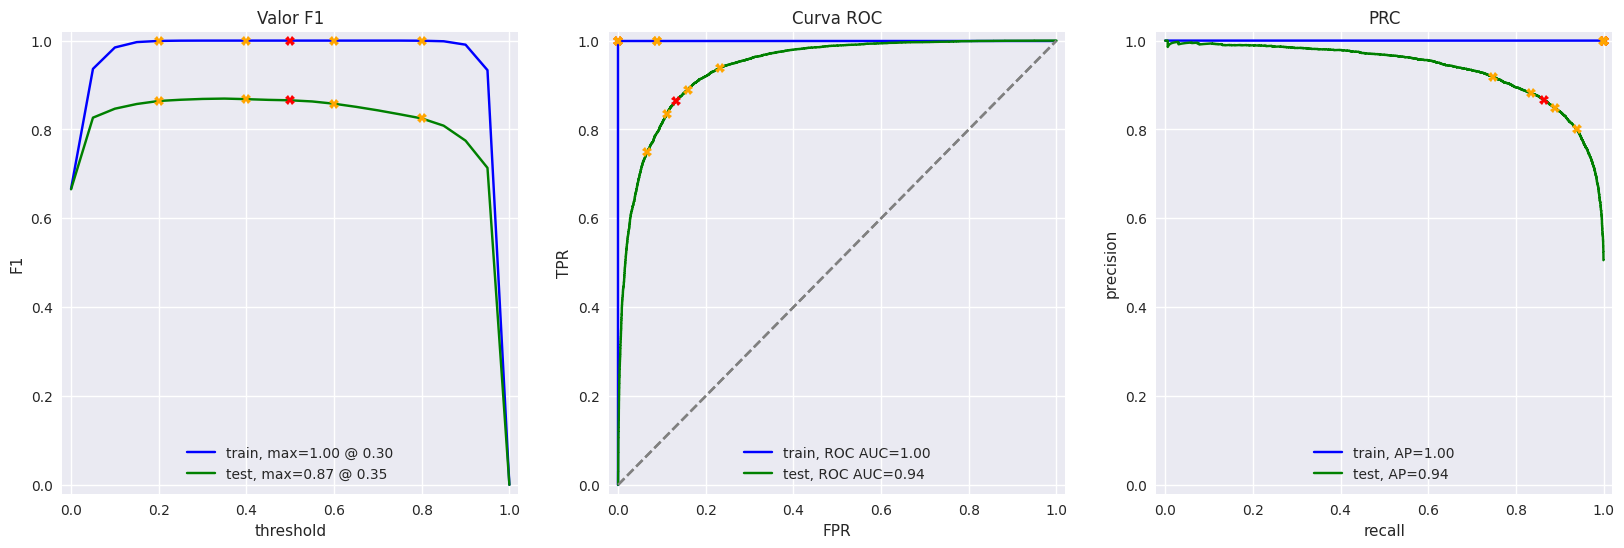

In [28]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

## Mis reseñas

In [29]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'\d+', '', regex=True).str.replace(r'[^\w\s]', '', regex=True)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",the pakage implies that warren beatty and gold...
1,"Well, I was bored and felt asleep in the middl...",how the hell did they get this made presenting...
2,I was really fascinated with the movie,there is no real story the film seems more lik...
3,Even the actors looked really old and disinter...,um a serious film about troubled teens in sin...
4,I didn't expect the reboot to be so good! Writ...,im totally agree with garryjohal from singapor...
5,"The movie had its upsides and downsides, but I...",this is the first movie ive seen from singapor...
6,What a rotten attempt at a comedy. Not a singl...,yes nonsingaporeans cant see whats the big dea...
7,Launching on Netflix was a brave move & I real...,this true story of carlsons raiders is more of...


### Modelo 2

In [32]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.04:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.08:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.34:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.88:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.75:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.92:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.73:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.23:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Modelo 3

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.04:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.18:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.34:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.70:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.75:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.94:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.85:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.30:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Modelo 4

In [37]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.00:  how the hell did they get this made presenting itself as a caper comedy the misbegotten  is essentia
0.06:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.96:  um  a serious film about troubled teens in singapore a country i have not much knowledge on but have
0.92:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
1.00:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.66:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.06:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro



<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Muy bien hecho! Has implementado múltiples modelos de clasificación de texto utilizando diferentes enfoques (NLTK, spaCy, TF-IDF, Logistic Regression y LightGBM), lo cual demuestra una comprensión sólida del flujo de trabajo en NLP. Aunque no se incluyó el modelo basado en BERT, está completamente bien, ya que su uso es opcional y los modelos implementados logran resultados competitivos. ¡Excelente trabajo explorando diversas alternativas!

</div>


## Conclusiones

A través de técnicas de preprocesamiento de texto (como la eliminación de stopwords y tokenización), fue posible entrenar modelos capaces de predecir sentimientos negativos en reseñas de películas.

Aunque no se utilizaron modelos complejos como BERT, fue posible obtener buenos resultados con modelos clásicos como regresión logística, lo que demuestra que no siempre se necesitan modelos sofisticados para este tipo de tareas.

# Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Felicidades! Tu proyecto está **aprobado**. Has hecho un trabajo excelente implementando una clasificación de texto con un enfoque metódico, utilizando varias herramientas fundamentales en NLP. A continuación, destaco los puntos fuertes de tu trabajo, así como ideas para seguir desarrollando tus habilidades en este campo:

---

### ✅ Puntos Positivos:

* **Estructura clara y bien organizada:** Seguiste adecuadamente la plantilla, lo cual facilita la comprensión del proyecto de principio a fin.
* **Evaluación detallada:** Implementaste un excelente sistema de evaluación visual con métricas como F1, ROC AUC y APS, lo que proporciona una interpretación más completa del desempeño del modelo.
* **Comparación de modelos:** Probaste múltiples enfoques (desde un modelo base hasta modelos TF-IDF con distintas bibliotecas), lo que es clave para entender cómo evoluciona el rendimiento.
* **Preprocesamiento textual:** Aplicaste correctamente técnicas como lematización, eliminación de stopwords y normalización textual.

---

### 📘 Contexto sobre NLP y BERT:

La evolución de los modelos de procesamiento de lenguaje natural ha pasado por varias etapas. Inicialmente, se basaban en métodos estadísticos simples y luego evolucionaron hacia técnicas de vectorización como **TF-IDF**, que tú aplicaste muy bien. Más tarde, modelos como **Word2Vec** y **GloVe** mejoraron la representación semántica del texto. Sin embargo, el verdadero salto cualitativo vino con el desarrollo de modelos **transformer**, siendo **BERT (Bidirectional Encoder Representations from Transformers)** uno de los más influyentes.

**¿Por qué BERT es importante?**

* Introdujo el concepto de **entendimiento bidireccional del contexto**, lo que significa que BERT comprende el significado de una palabra según todas las palabras a su alrededor (no solo las anteriores o posteriores).
* Está **preentrenado en grandes volúmenes de datos**, lo que le permite entender relaciones lingüísticas complejas incluso con pocas muestras.
* Representa el **estado del arte** en muchas tareas de NLP como clasificación, análisis de sentimientos, respuesta a preguntas y más.

**Aunque no implementaste BERT en este proyecto, tu enfoque fue sólido y coherente.** Entender y dominar las técnicas previas es una base esencial antes de abordar modelos como BERT, que también requieren más recursos computacionales y conocimiento de arquitecturas de redes neuronales.

---

### 💡 Áreas para Seguir Investigando:

* **Implementación de modelos preentrenados como BERT con HuggingFace Transformers.**
* **Ajuste fino de modelos transformadores para tareas específicas.**
* **Uso de técnicas de optimización y tuning más avanzadas como Grid Search, Optuna o Bayesian Optimization.**
* **Evaluación cruzada estratificada para conjuntos de datos desequilibrados.**

¡Sigue así, estás haciendo un gran trabajo y tienes un futuro prometedor en el campo del NLP! 💪🚀📚

</div>


# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 